In [1]:
pip install tensorflow keras opencv-python matplotlib seaborn scikit-learn pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


2025-08-29 14:04:37.703668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756476277.907549      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756476277.963911      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

plt.style.use('ggplot')

In [4]:
def load_data(data_path):
    images = []
    labels = []
    class_dirs = sorted(os.listdir(data_path))
    
    for class_dir in class_dirs:
        class_path = os.path.join(data_path, class_dir)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (32, 32))
                    images.append(img)
                    labels.append(int(class_dir))
    
    return np.array(images), np.array(labels)

In [5]:
class GTSRBDataLoader:
    def __init__(self, data_path):
        self.data_path = data_path
        self.img_height = 32
        self.img_width = 32
        self.num_classes = 43
        
    def load_data(self):

        images = []
        labels = []
        
        train_csv = pd.read_csv(os.path.join(self.data_path, 'Train.csv'))
        
        for index, row in train_csv.iterrows():
            img_path = os.path.join(self.data_path, row['Path'])
            img = cv2.imread(img_path)
            
            if img is not None:
                img = self.preprocess_image(img)
                images.append(img)
                labels.append(row['ClassId'])
        
        images = np.array(images)
        labels = np.array(labels)
        
        return images, labels
    
    def preprocess_image(self, img):

        img = cv2.resize(img, (self.img_width, self.img_height))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype('float32') / 255.0
        return img
    
    def load_test_data(self):

        test_images = []
        test_labels = []
        
        test_csv = pd.read_csv(os.path.join(self.data_path, 'Test.csv'))
        
        for index, row in test_csv.iterrows():
            img_path = os.path.join(self.data_path, row['Path'])
            img = cv2.imread(img_path)
            
            if img is not None:
                img = self.preprocess_image(img)
                test_images.append(img)
                test_labels.append(row['ClassId'])
        
        return np.array(test_images), np.array(test_labels)

data_loader = GTSRBDataLoader('/kaggle/input/gtsrb-german-traffic-sign')

Dataset shape: (39209, 32, 32, 3)
Labels shape: (39209,)
Number of classes: 43


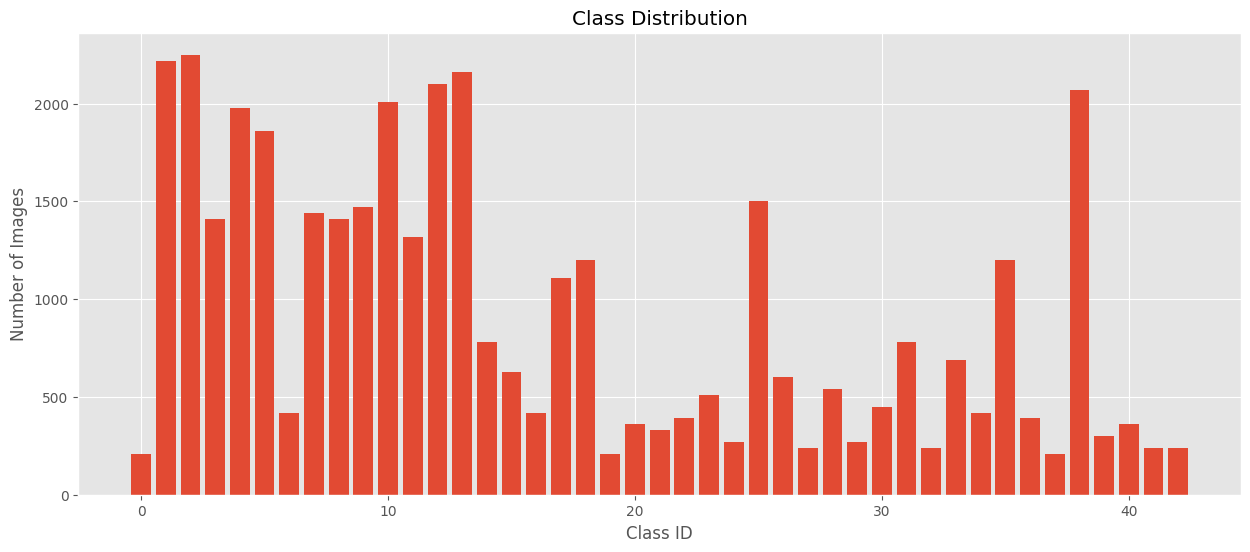

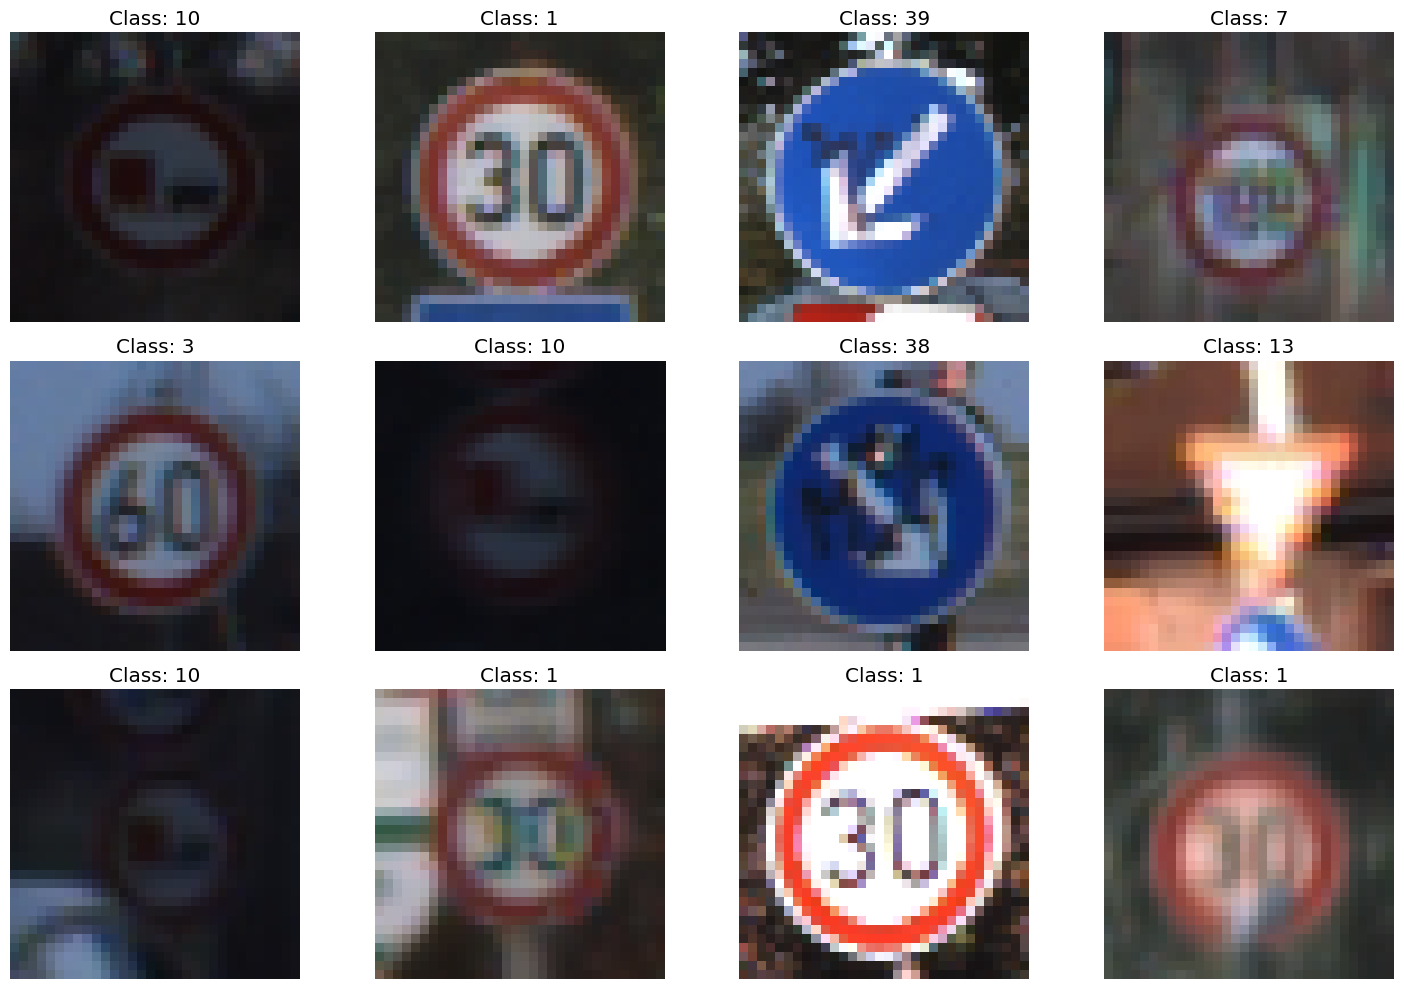

In [6]:
def explore_dataset(images, labels):
    print(f"Dataset shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Number of classes: {len(np.unique(labels))}")
    
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(15, 6))
    plt.bar(unique, counts)
    plt.title('Class Distribution')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Images')
    plt.show()
    
    plt.figure(figsize=(15, 10))
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        idx = np.random.randint(0, len(images))
        plt.imshow(images[idx])
        plt.title(f'Class: {labels[idx]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

images, labels = data_loader.load_data()
explore_dataset(images, labels)

In [7]:
def prepare_data(images, labels, test_size=0.2, val_size=0.1):
    labels_one_hot = to_categorical(labels, num_classes=43)
    
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels_one_hot, test_size=test_size, random_state=42, stratify=labels
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, random_state=42, stratify=np.argmax(y_train, axis=1)
    )
    
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(images, labels)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=False,  
    fill_mode='nearest'
)
datagen.fit(X_train)

Training set: (28230, 32, 32, 3)
Validation set: (3137, 32, 32, 3)
Test set: (7842, 32, 32, 3)


In [8]:
def create_cnn_model(input_shape, num_classes):
    """Create CNN model for traffic sign classification"""
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Fully connected layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

In [9]:
input_shape = (32, 32, 3)
model = create_cnn_model(input_shape, 43)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1756476515.808634      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,483,339 (5.66 MB)

 Trainable params: 1,480,907 (5.65 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50


I0000 00:00:1756476527.167124      68 service.cc:148] XLA service 0x7f624400ac60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756476527.167811      68 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756476528.117935      68 cuda_dnn.cc:529] Loaded cuDNN version 90300


 26/883 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0443 - loss: 5.0630

I0000 00:00:1756476535.331050      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


883/883 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.2771 - loss: 3.0212 - val_accuracy: 0.9302 - val_loss: 0.2380 - learning_rate: 0.0010
Epoch 2/50
883/883 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8832 - loss: 0.3755 - val_accuracy: 0.9898 - val_loss: 0.0408 - learning_rate: 0.0010
Epoch 3/50
883/883 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9565 - loss: 0.1480 - val_accuracy: 0.9882 - val_loss: 0.0368 - learning_rate: 0.0010
Epoch 4/50
883/883 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9692 - loss: 0.0988 - val_accuracy: 0.9904 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 5/50
883/883 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9700 - loss: 0.1008 - val_accuracy: 0.9901 - val_loss: 0.0378 - learning_rate: 0.0010
Epoch 6/50
883/883 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9779 - loss: 0.0685 - val_accuracy: 0.9955 - val_loss: 0.0179 - learning_rate: 0.0010
Epoch 7/50
883/883 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9858 - loss: 0.0458 - val_accur

In [11]:
def evaluate_model(model, X_test, y_test):
    """Evaluate model performance"""
    # Test accuracy
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes))
    
    return y_true_classes, y_pred_classes

# Evaluate model
y_true, y_pred = evaluate_model(model, X_test, y_test)

Test Accuracy: 0.9990
Test Loss: 0.0054
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       444
           2       1.00      1.00      1.00       450
           3       1.00      1.00      1.00       282
           4       0.99      1.00      1.00       396
           5       1.00      0.99      1.00       372
           6       1.00      1.00      1.00        84
           7       1.00      1.00      1.00       288
           8       1.00      1.00      1.00       282
           9       1.00      1.00      1.00       294
          10       1.00      1.00      1.00       402
          11       1.00      1.00      1.00       264
          12       1.00      1.00      1.00       420
          13       1.00      1.00      1.00       432
          14       1.00      1.00      1.00       156
          15       1.00      1

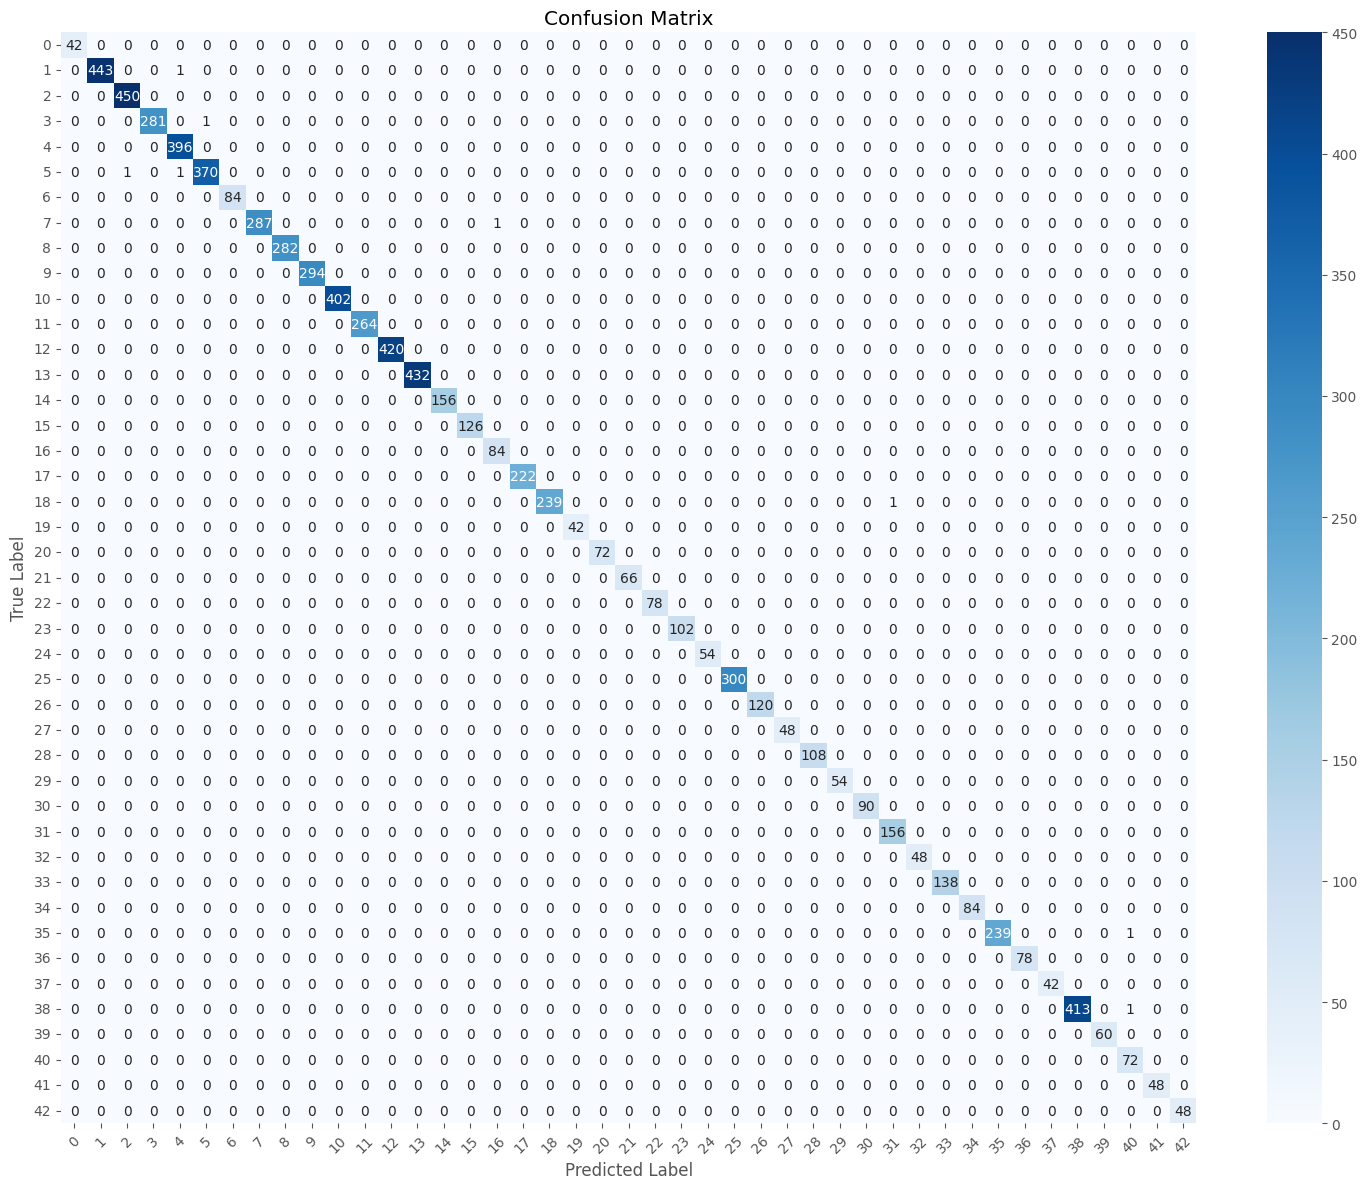

In [12]:
def plot_confusion_matrix(y_true, y_pred, class_names=None):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names if class_names else range(43),
                yticklabels=class_names if class_names else range(43))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)

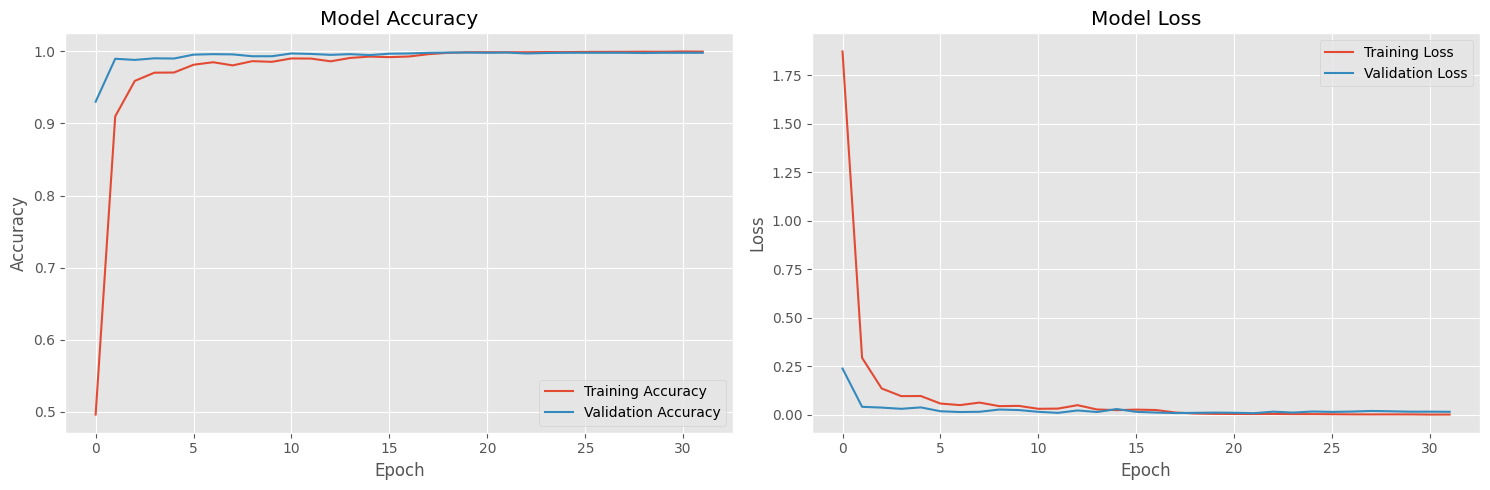

In [13]:
def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


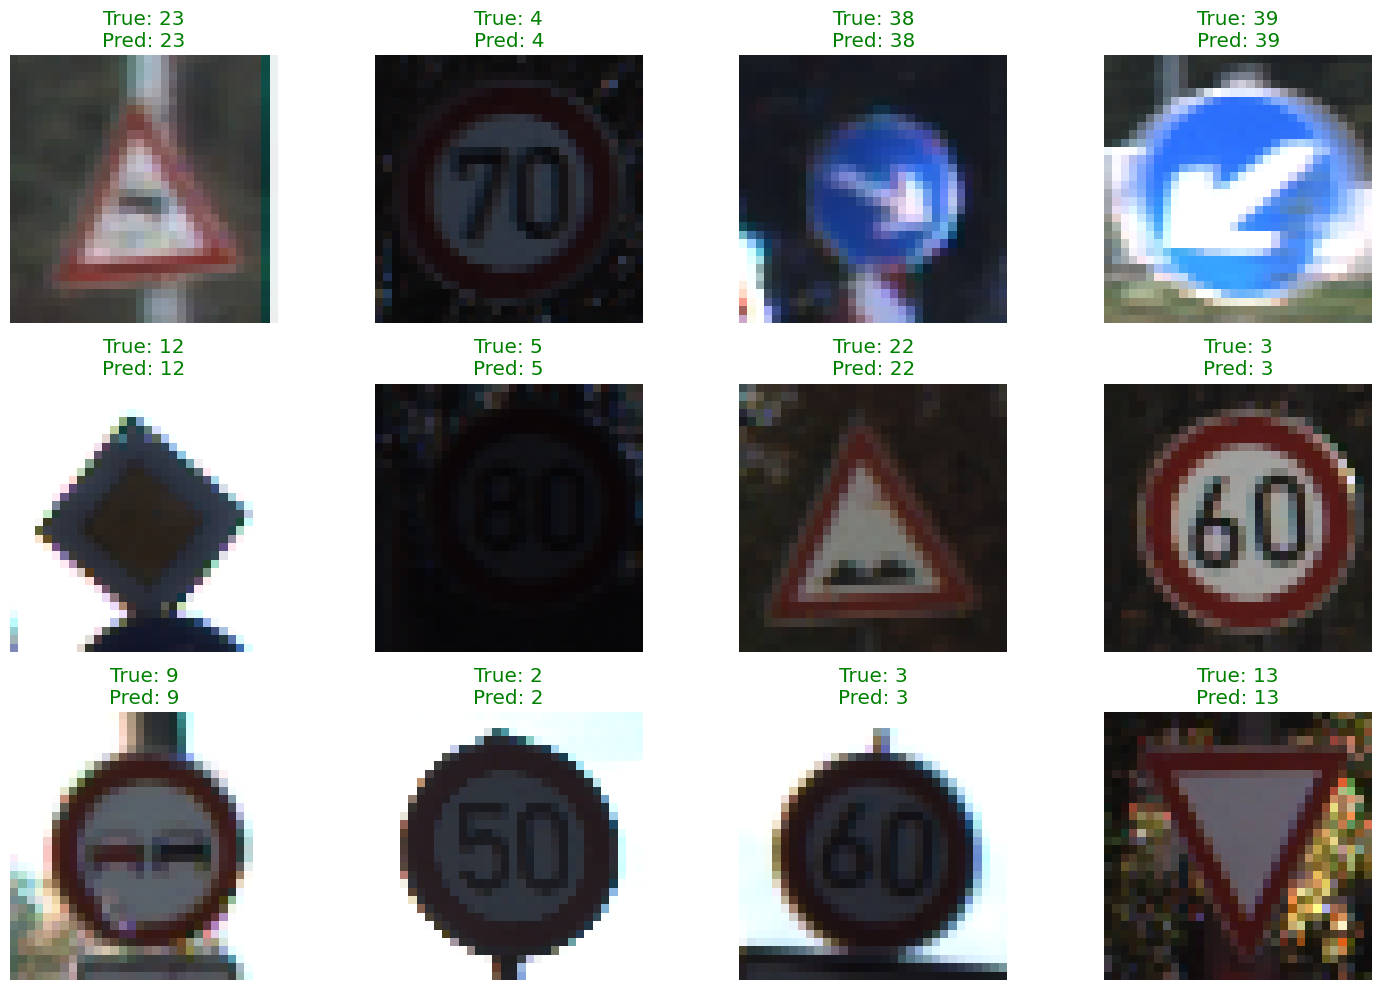

In [14]:
def visualize_predictions(model, X_test, y_test, num_samples=12):
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    sample_images = X_test[indices]
    sample_true = np.argmax(y_test[indices], axis=1)
    
    predictions = model.predict(sample_images)
    sample_pred = np.argmax(predictions, axis=1)
    
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(3, 4, i + 1)
        plt.imshow(sample_images[i])
        color = 'green' if sample_true[i] == sample_pred[i] else 'red'
        plt.title(f'True: {sample_true[i]}\nPred: {sample_pred[i]}', color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(model, X_test, y_test)

In [15]:
model.save('traffic_sign_classifier.h5')
print("Model saved successfully!")



Model saved successfully!


In [16]:
def predict_traffic_sign(image_path, model):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not load image")
        return None
    
    img = cv2.resize(img, (32, 32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    
    return predicted_class, confidence

